## Pre Step 2: Spectrum model

### Overview

We forward model the spectral traces on the detector using Neon lamp data. The relevant files will be made available upon request. The resulting spectrum model are stored in `specmodel` in this directory.

In [2]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

import PLred.visPLred.spec as sp

In [3]:
# Load Neon lamp data
neon_chunk = fits.getdata('/mnt/datazpool/PL/yjkim/BETACMI_f/1_visPLred_data_reduction/calib_data/wavcals/20240914/PL_Neon.fits')
neon_dark_chunk = fits.getdata('/mnt/datazpool/PL/yjkim/BETACMI_f/1_visPLred_data_reduction/calib_data/wavcals/20240914/PL_Neon_dark.fits')

# Load High S/N data
target_chunk = fits.getdata('/mnt/datazpool/PL/20240917/firstpl/firstpl_15:00:17.183805078.fits')
target_dark_chunk = fits.getdata('/mnt/datazpool/PL/20240917/firstpl/firstpl_15:11:17.474454270.fits')


In [ ]:
# Average frames and subtract darks

neon = np.mean(neon_chunk, axis=0) - np.mean(neon_dark_chunk, axis=0)
target = np.mean(target_chunk, axis=0) - np.mean(target_dark_chunk, axis=0)


In [5]:
# Initialize SpectrumModel object

modelname = './specmodel'
sm = sp.SpectrumModel(modelname)

model will be saved in ./specmodel


In [6]:
# Store data in SpectrumModel object
sm.neon = neon
sm.flat = target

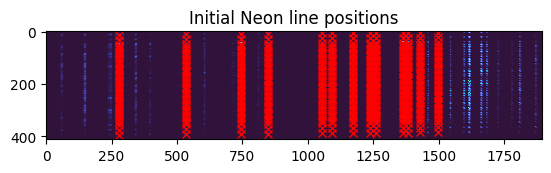

In [7]:
# Find peaks in neon spectrum. Note this depends on INI_XS, INI_YS parameters of SpectrumModel object
sm.find_peaks(use_peakutils=True, thres = 0.03)

100%|██████████| 38/38 [00:01<00:00, 21.61it/s]


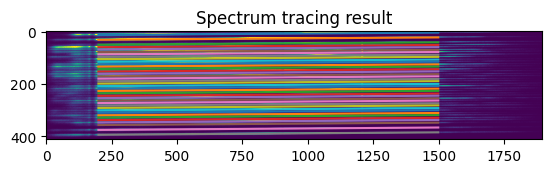

In [8]:
# Trace spectra. ini_wav_ind is the starting neon line index of the tracing.
ini_wav_ind = 3 # the index of the Neon line to start tracing from
sm.trace_spectra(ini_wav_ind)


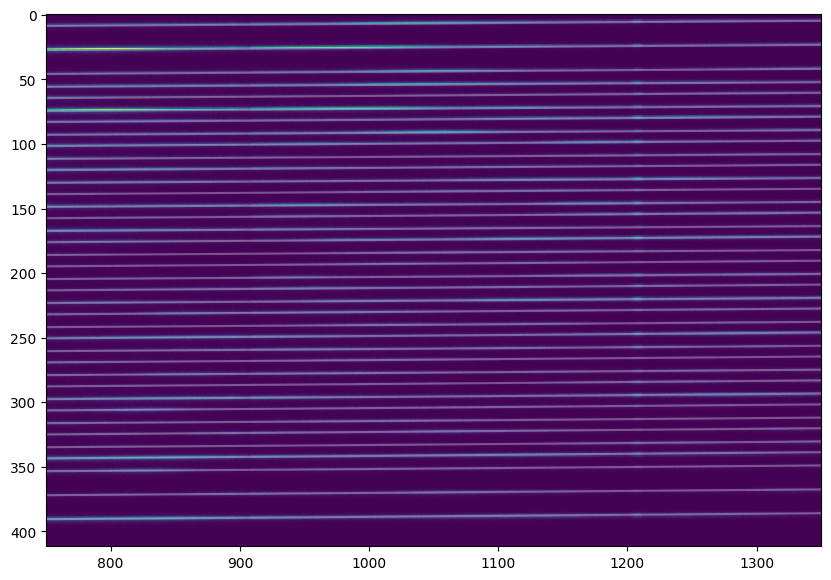

In [ ]:
# closer in look to check if the traces are good
plt.figure(figsize=(10,10))
plt.imshow(sm.flat)
plt.xlim([750,1350])
sm.plot_traces()

Now we carefully make cutout line spread functions (LSF).

/home/first/yjkim/PLred/PLred/imageutils.py:54: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(parabolic_2d, (x_coords, y_coords), intensities, p0=initial_guess) #,


fibind 8, wavind 0 failed
operands could not be broadcast together with shapes (0,6) (11,6) (0,6) 
fibind 18, wavind 0 failed
operands could not be broadcast together with shapes (0,7) (13,7) (0,7) 


/home/first/yjkim/PLred/PLred/visPLred/spec.py:583: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(ncols=self.NWAV, figsize=(self.NWAV * 2, 2))


fibind 22, wavind 0 failed
operands could not be broadcast together with shapes (0,6) (11,6) (0,6) 
fibind 23, wavind 0 failed
The number of func parameters=6 must not exceed the number of data points=4


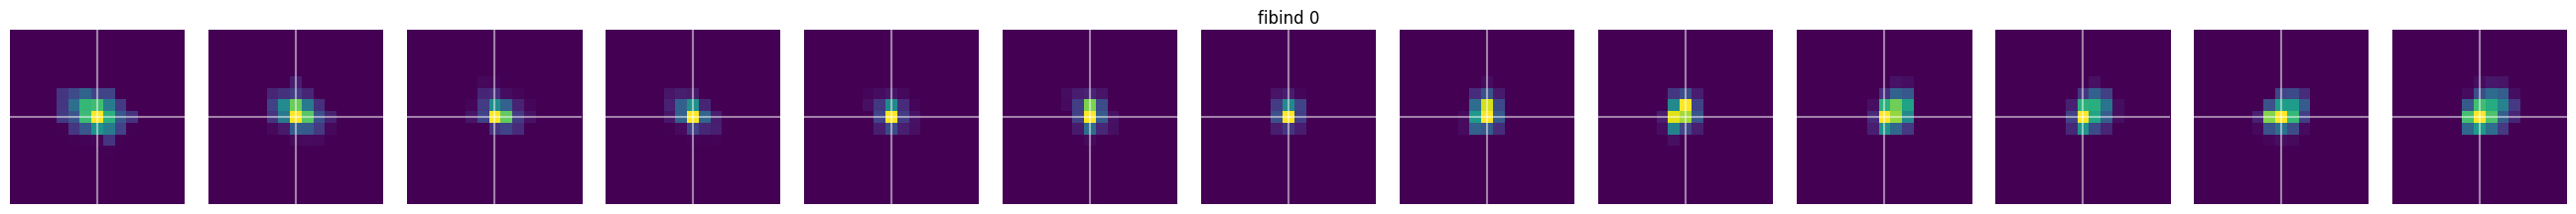

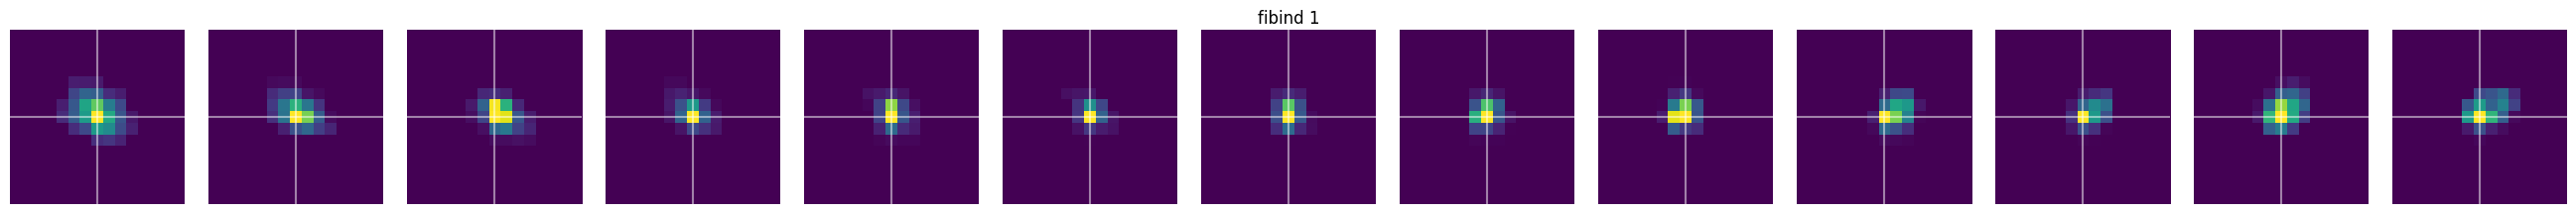

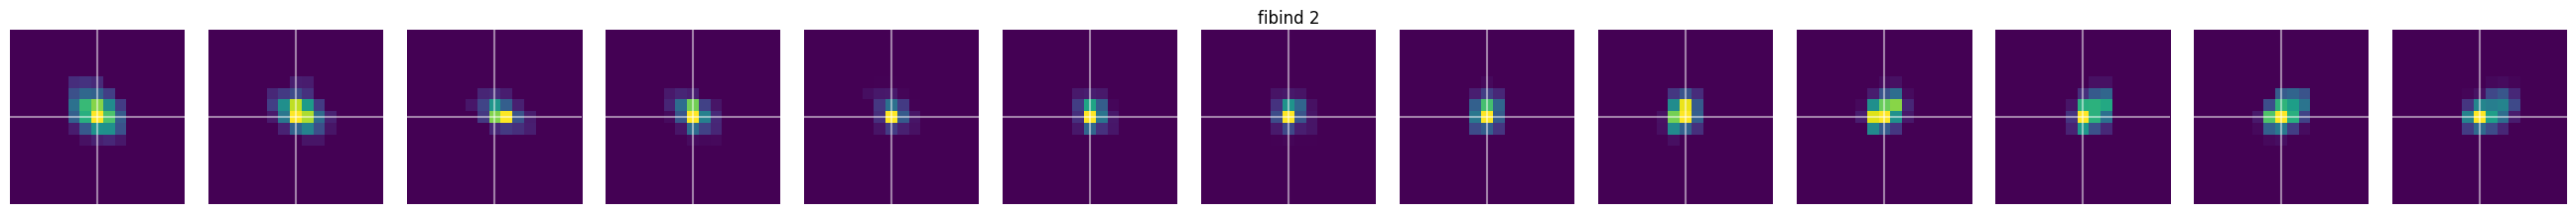

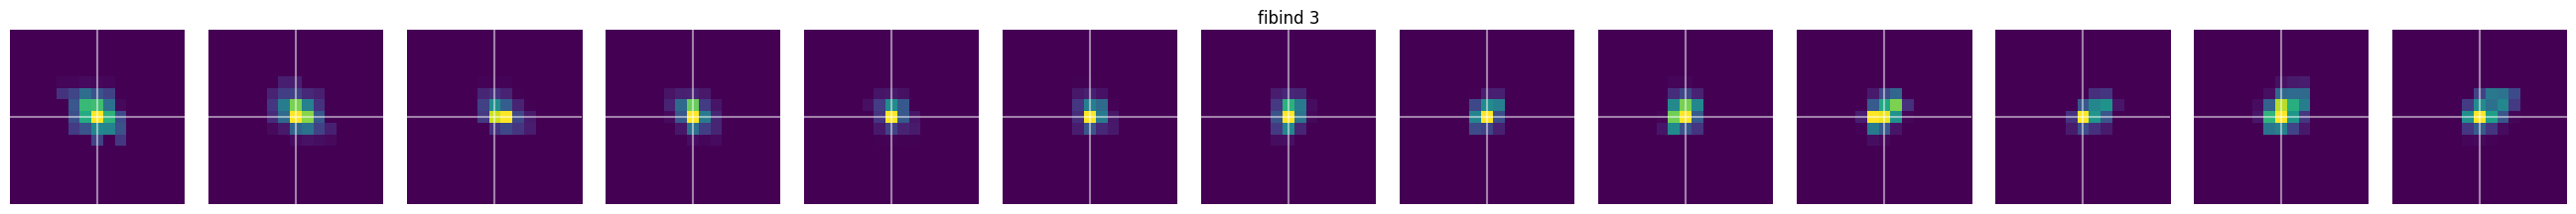

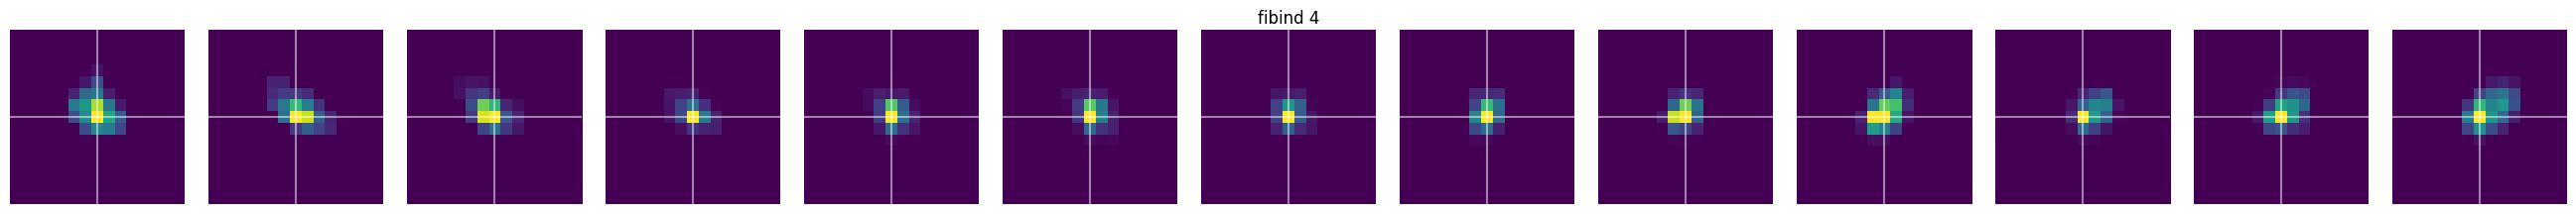

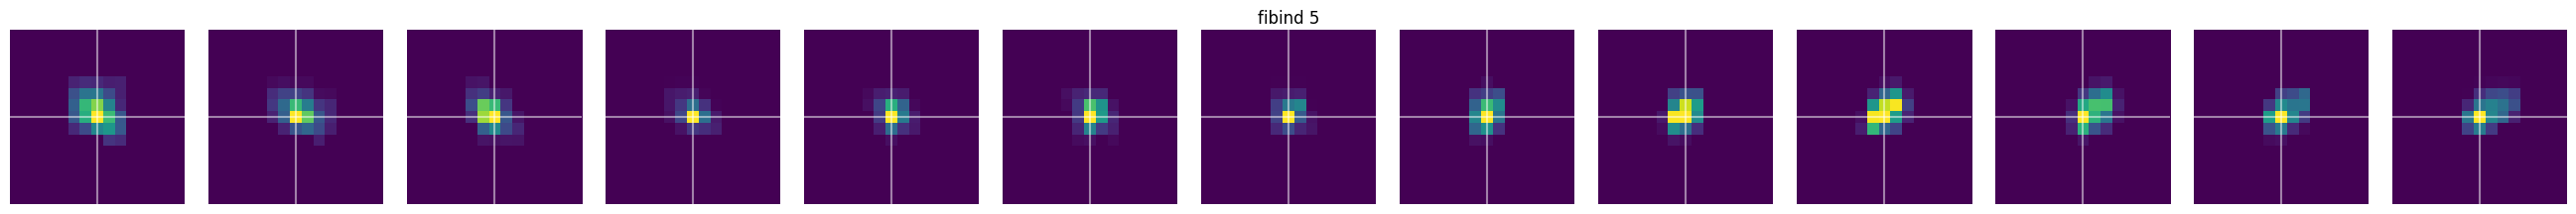

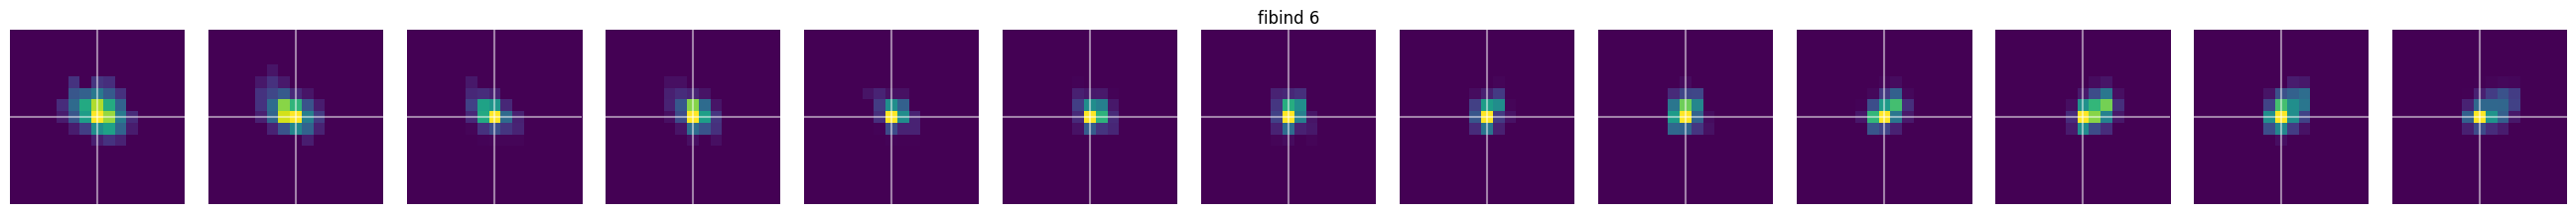

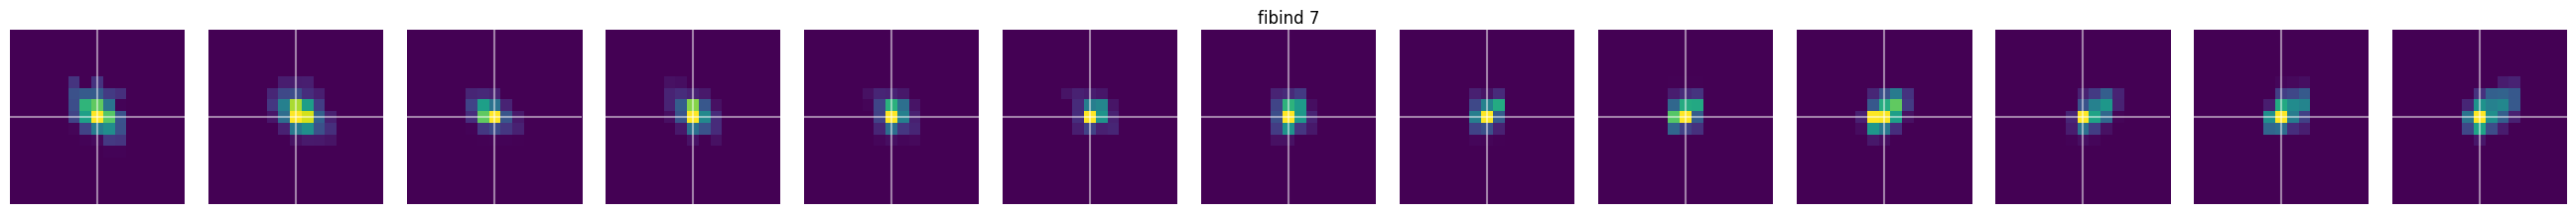

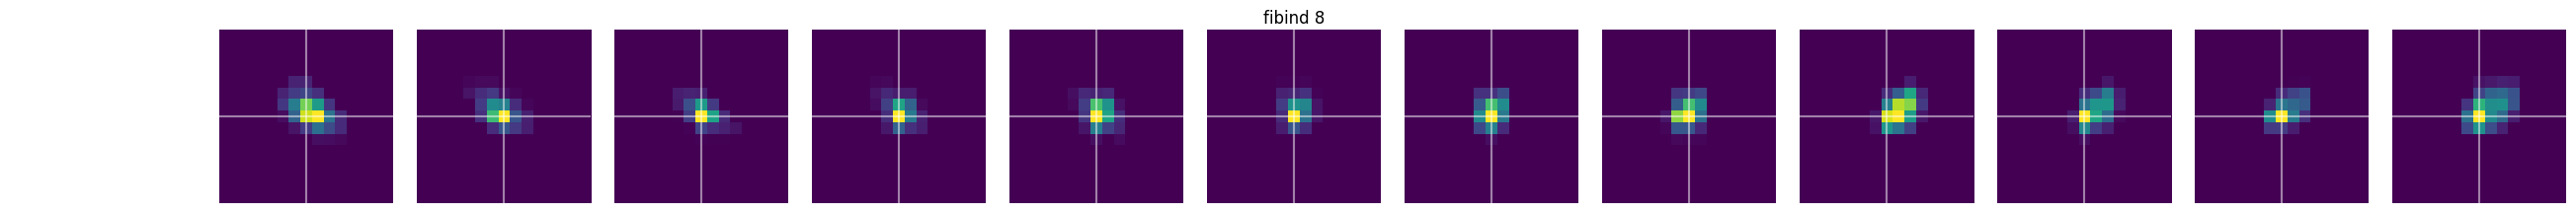

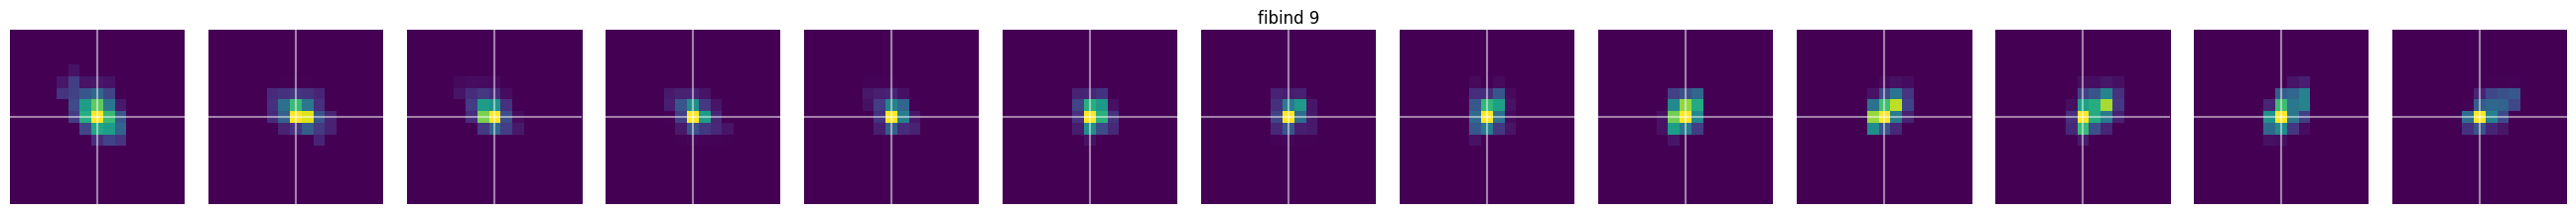

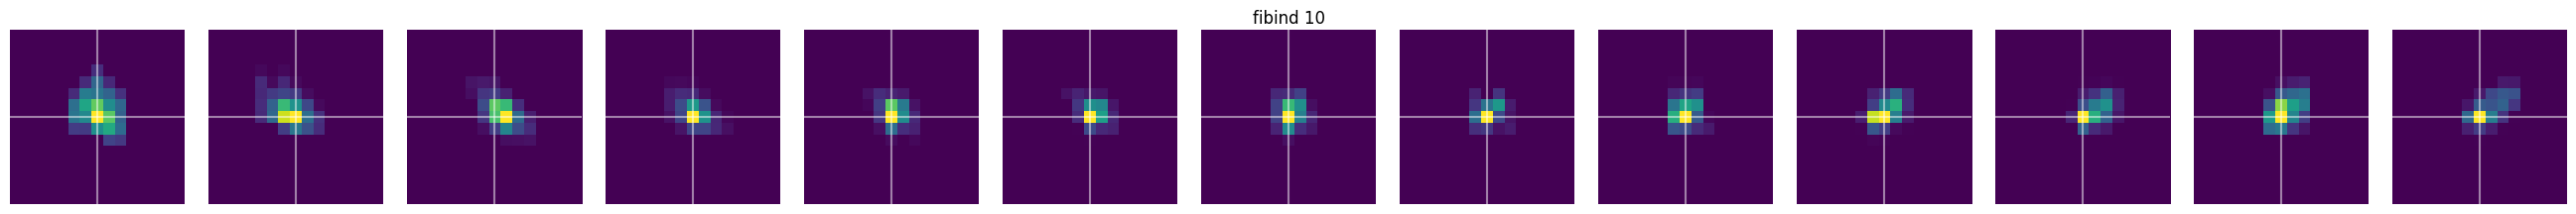

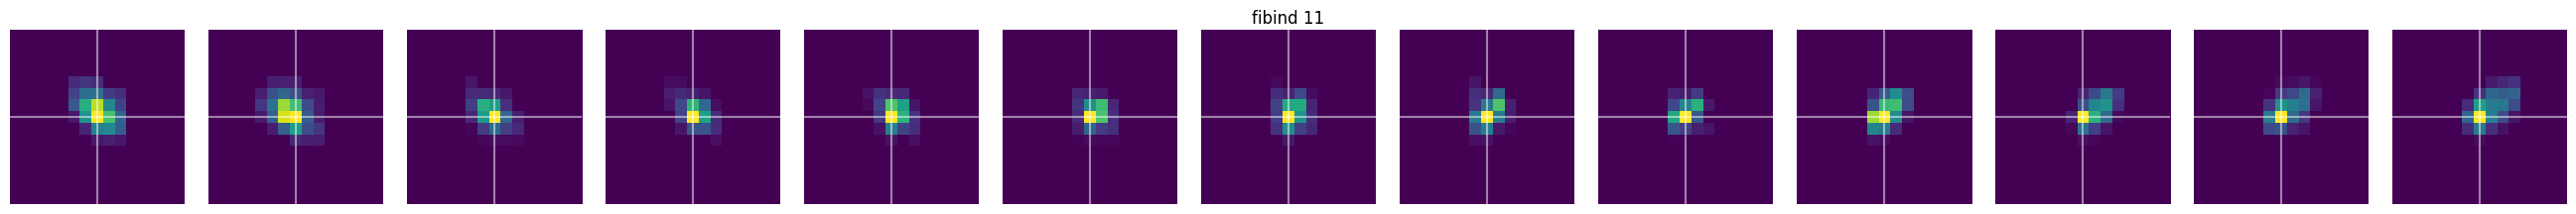

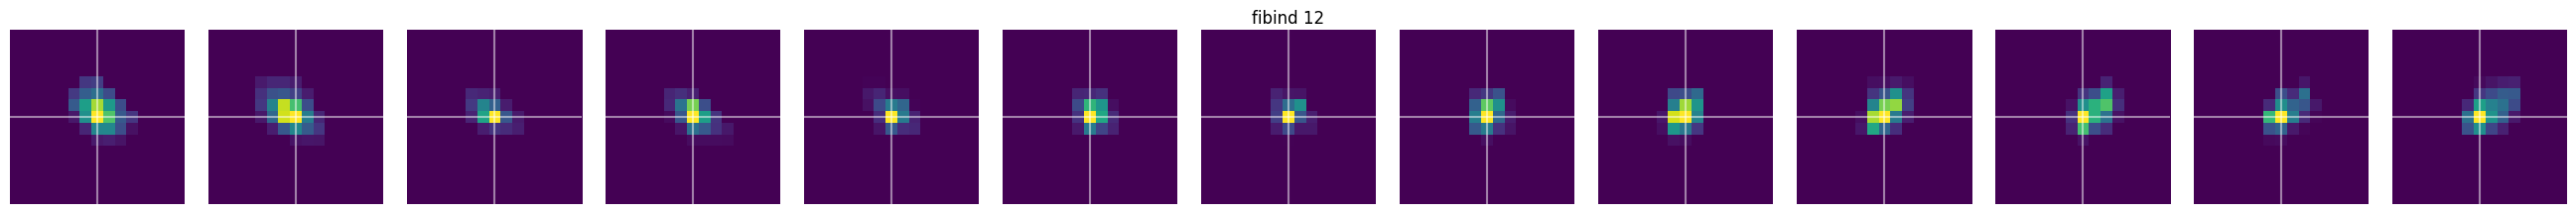

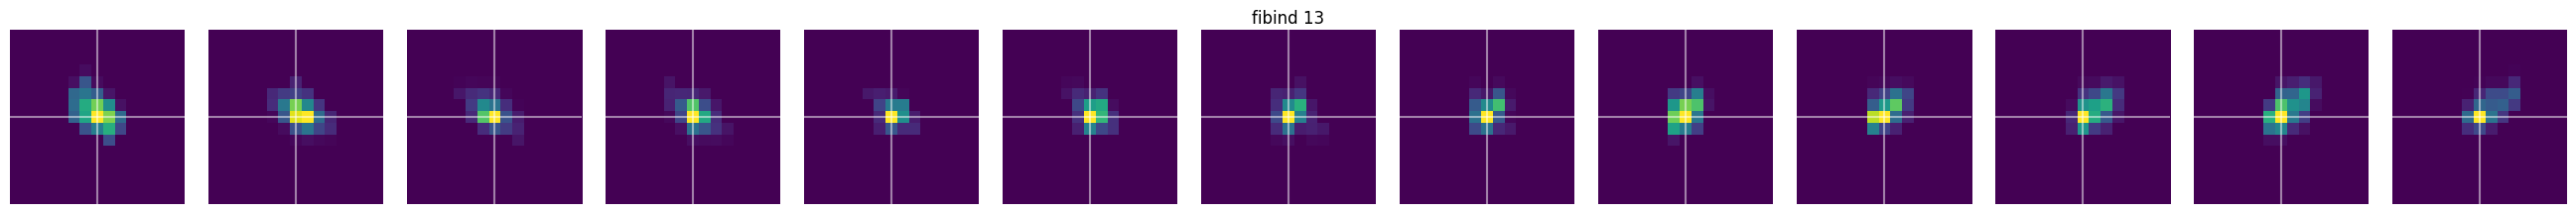

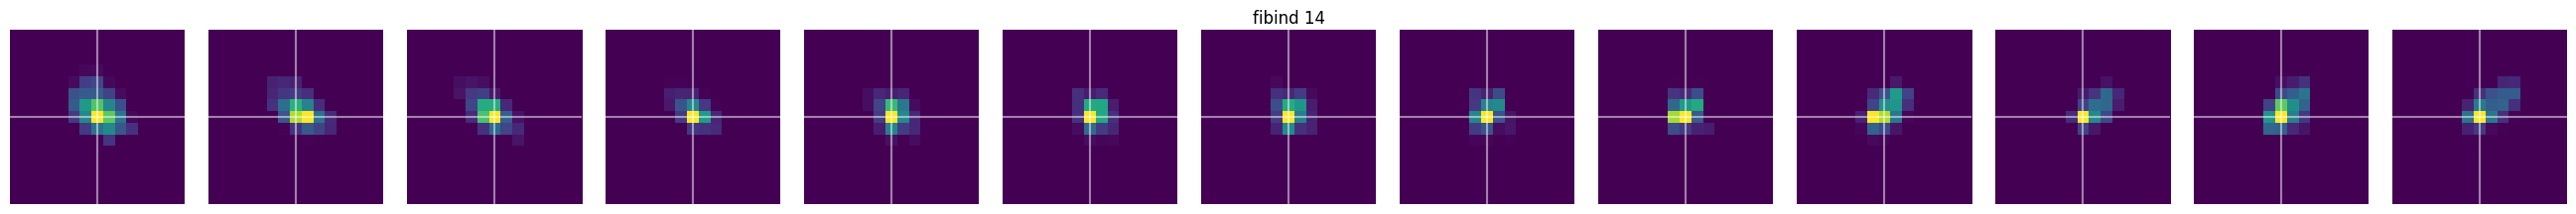

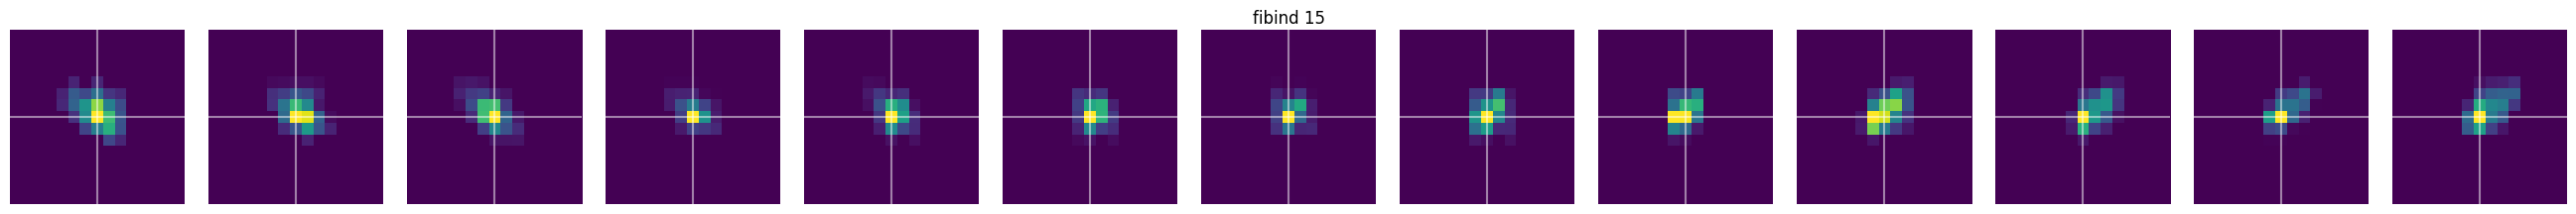

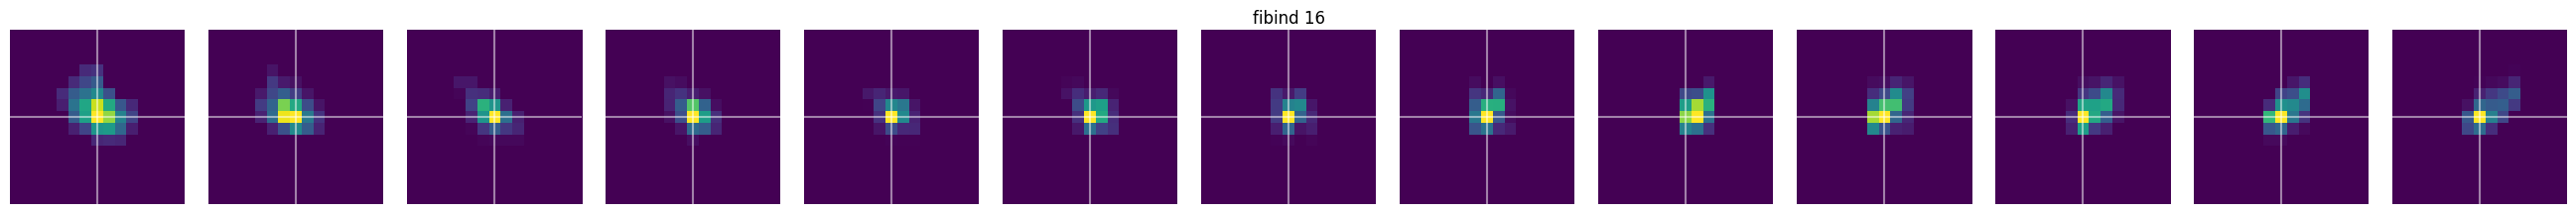

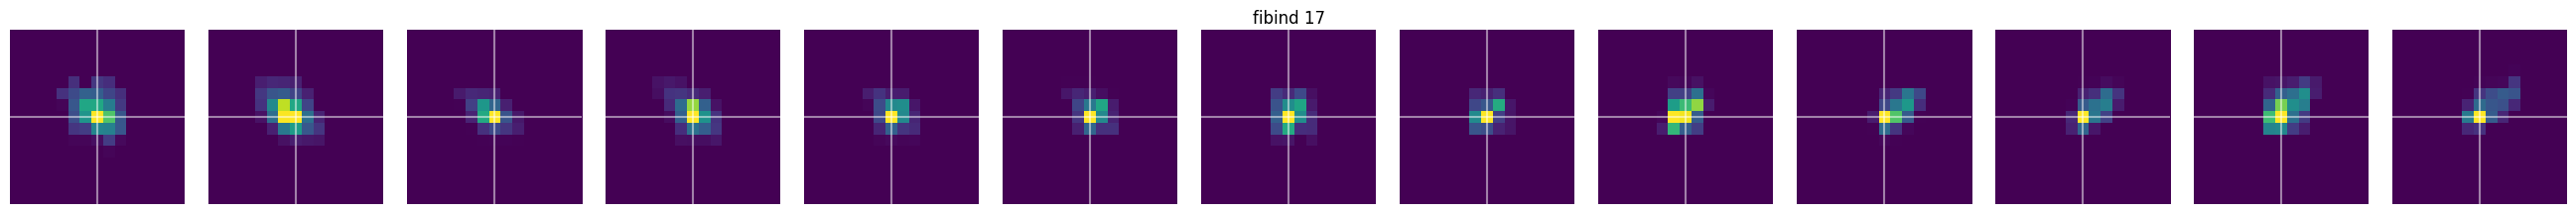

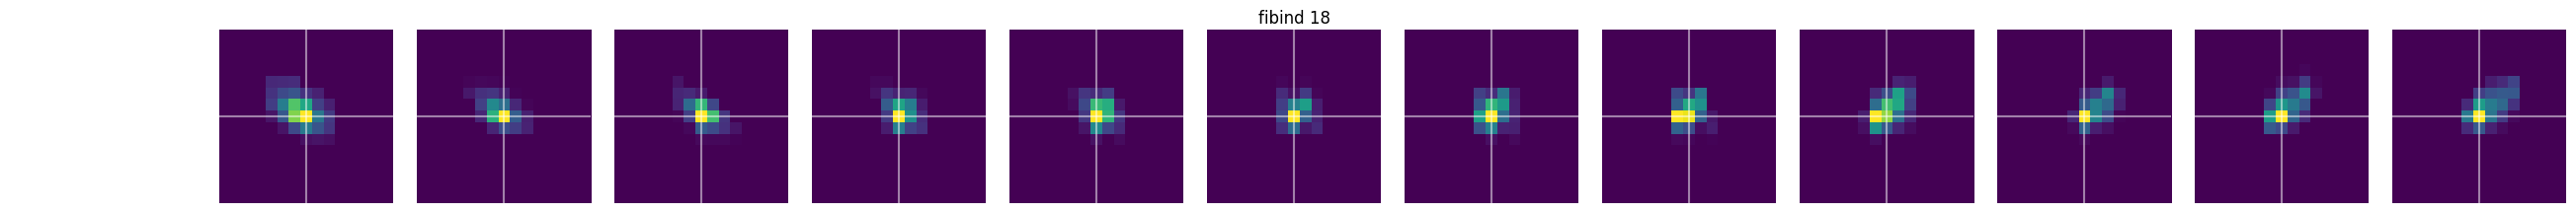

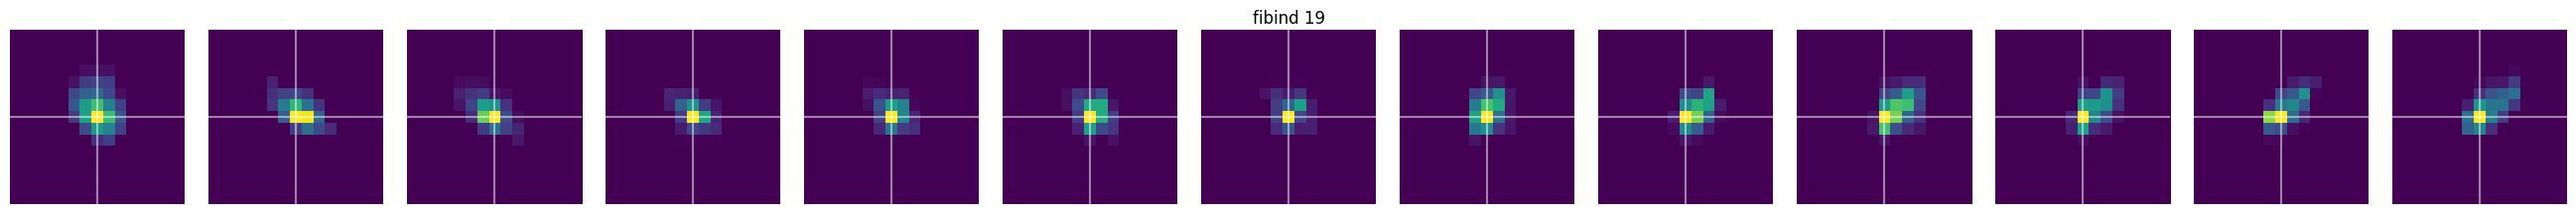

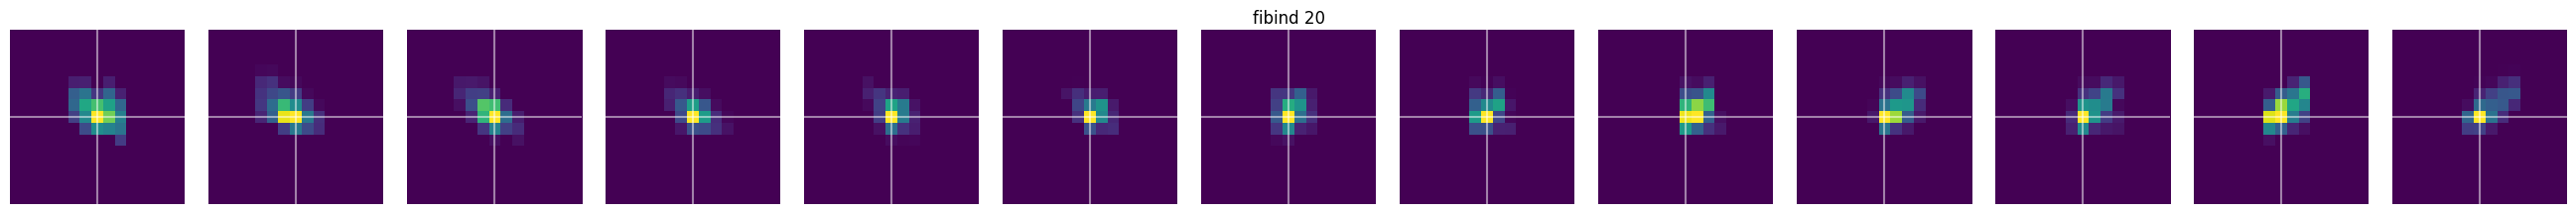

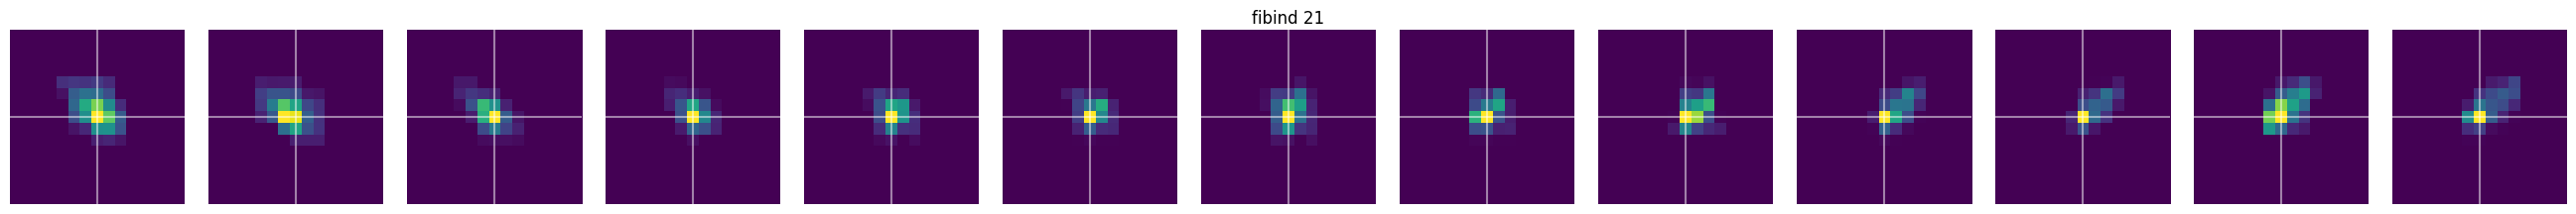

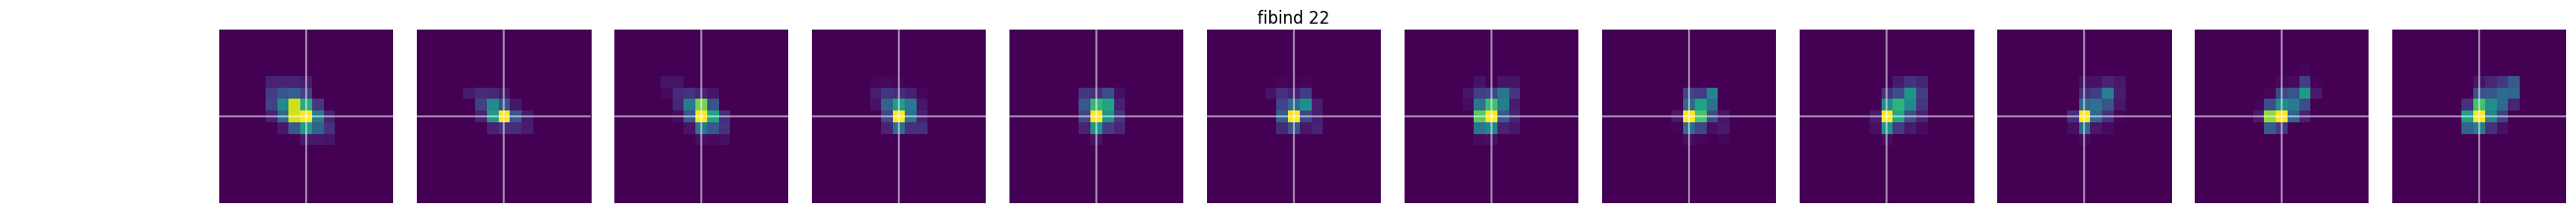

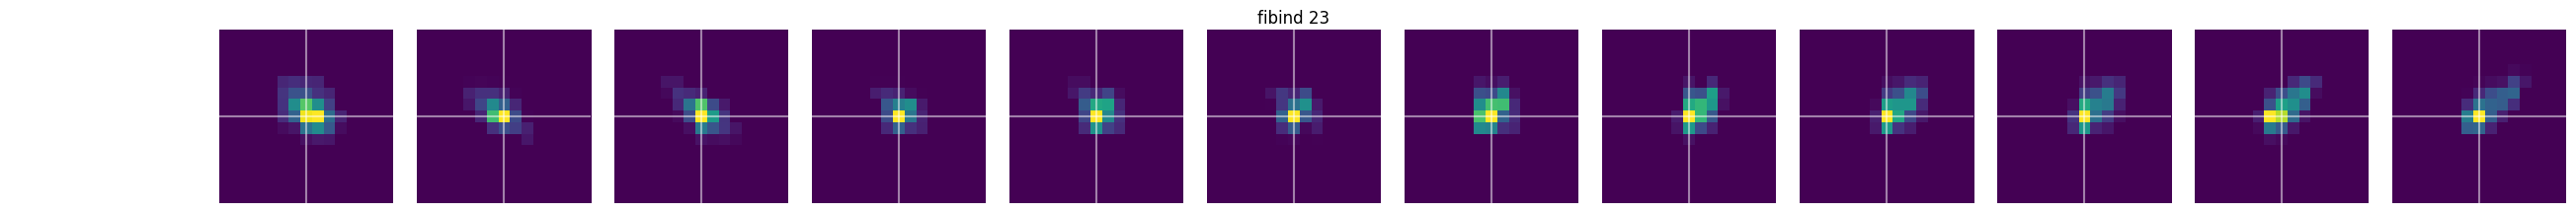

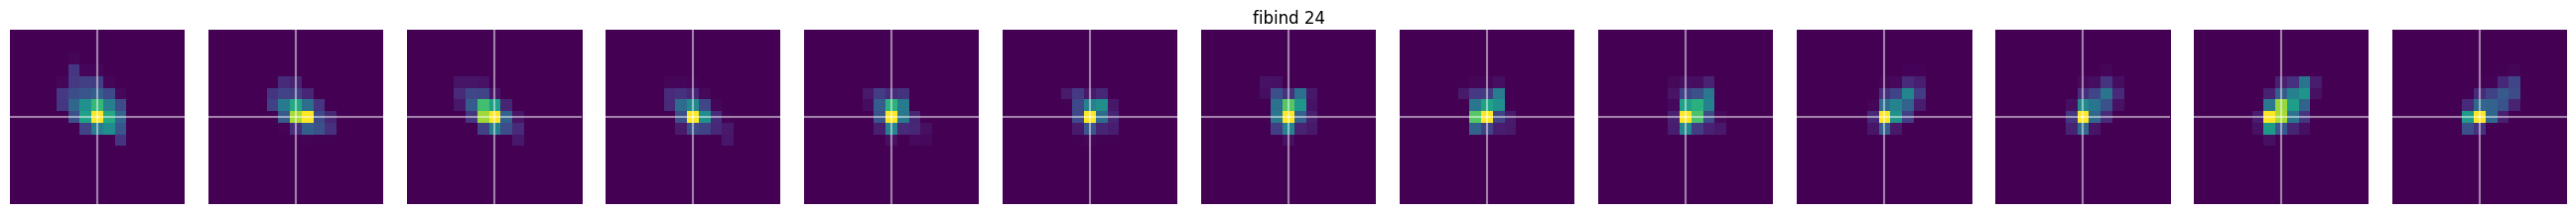

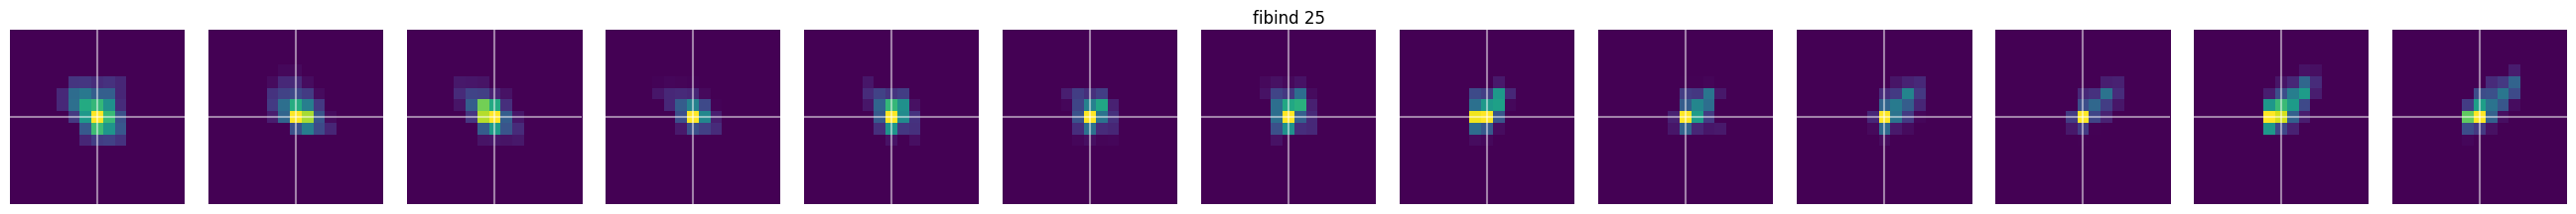

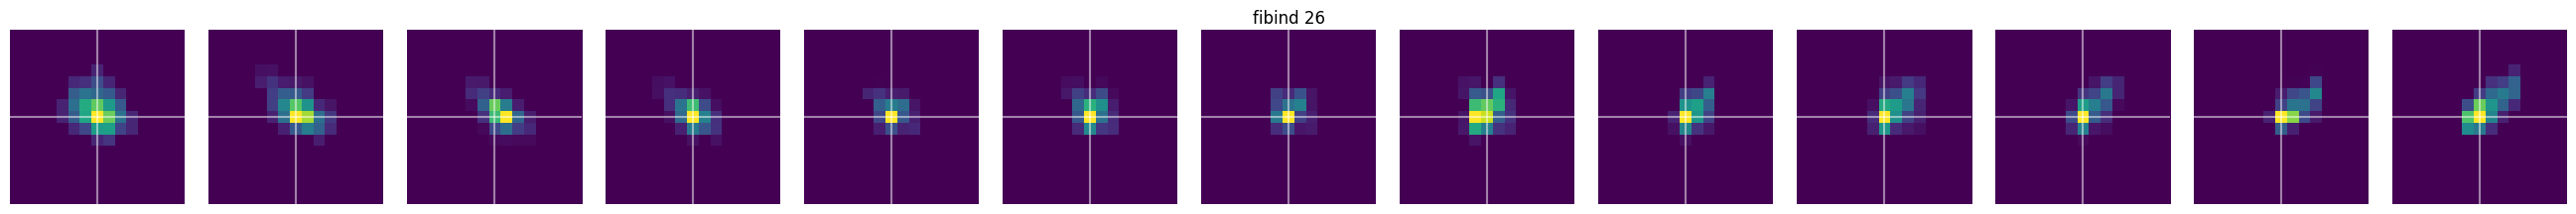

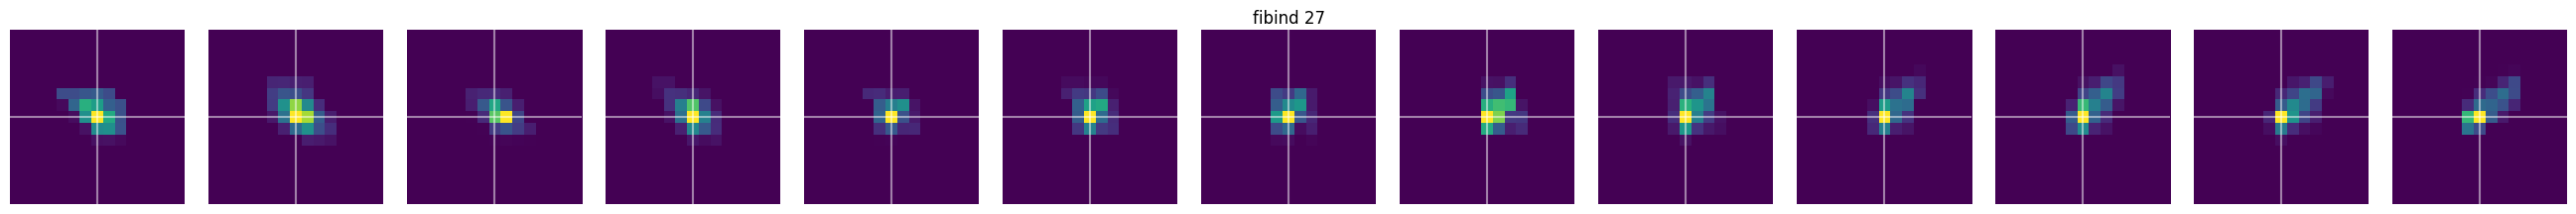

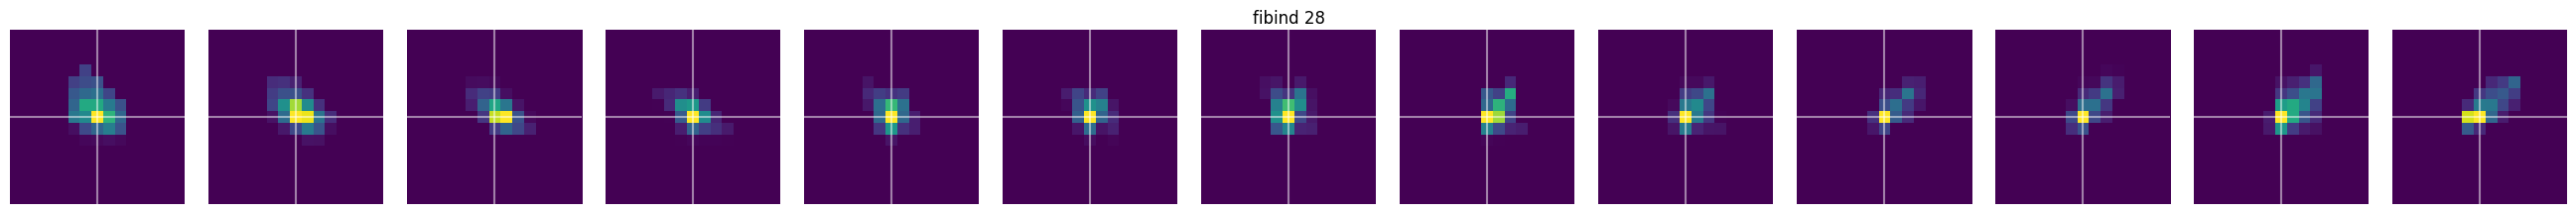

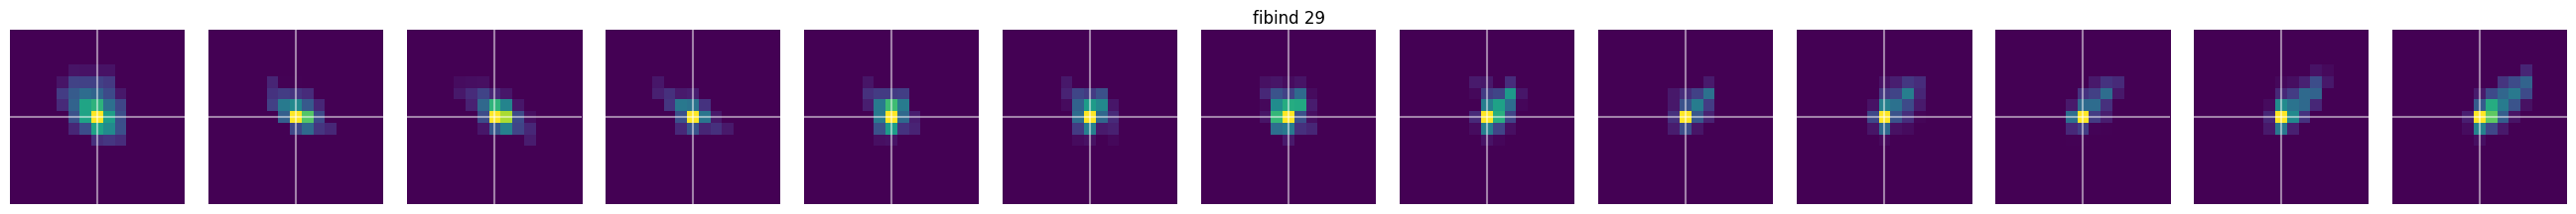

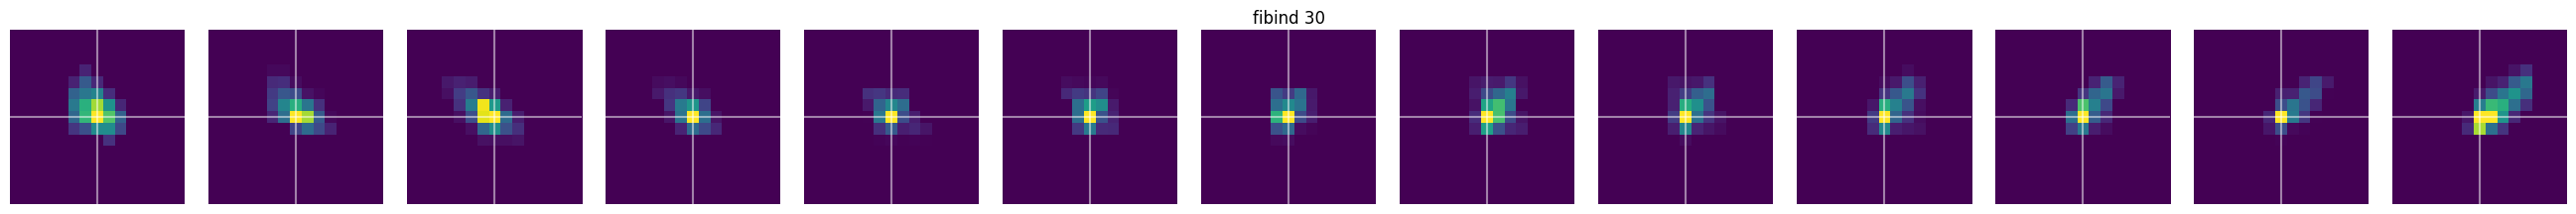

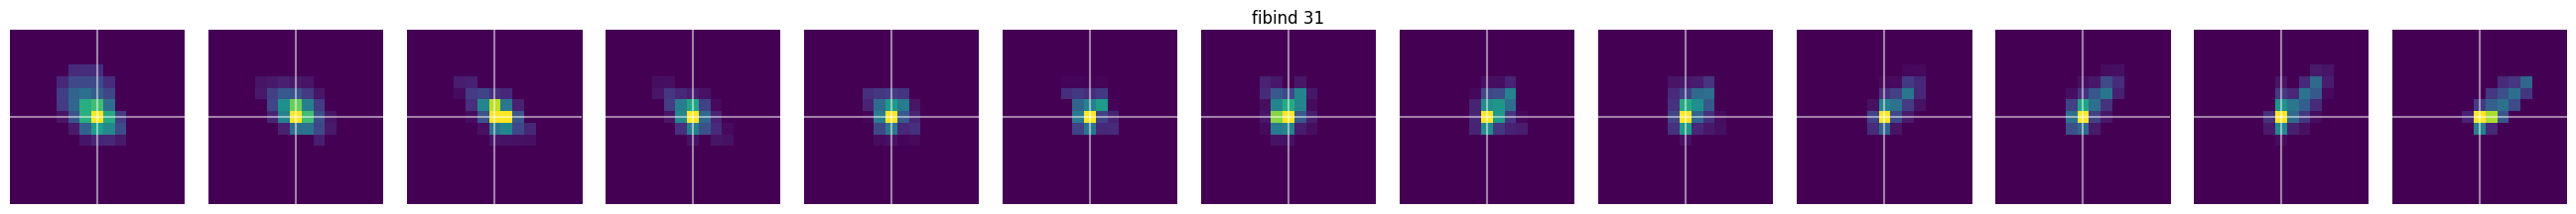

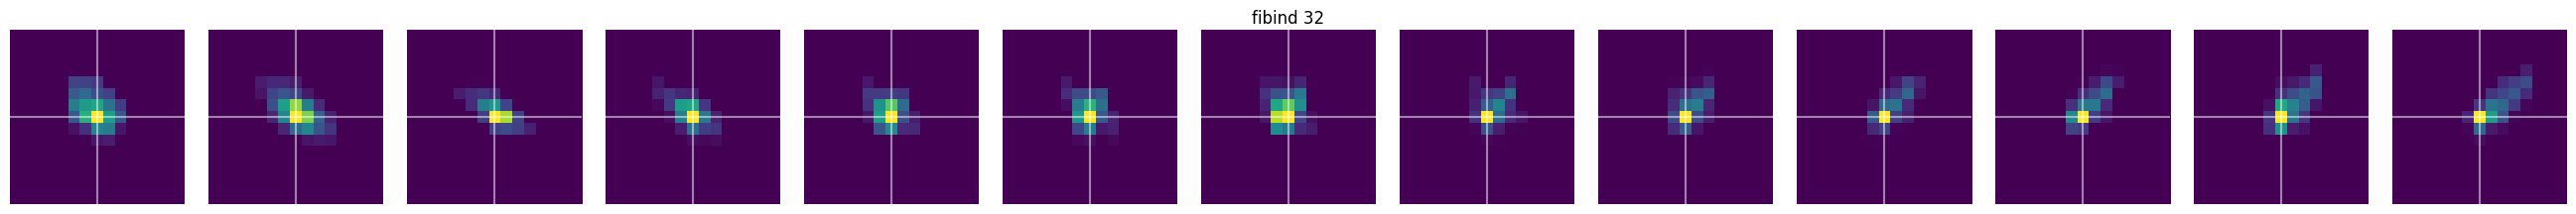

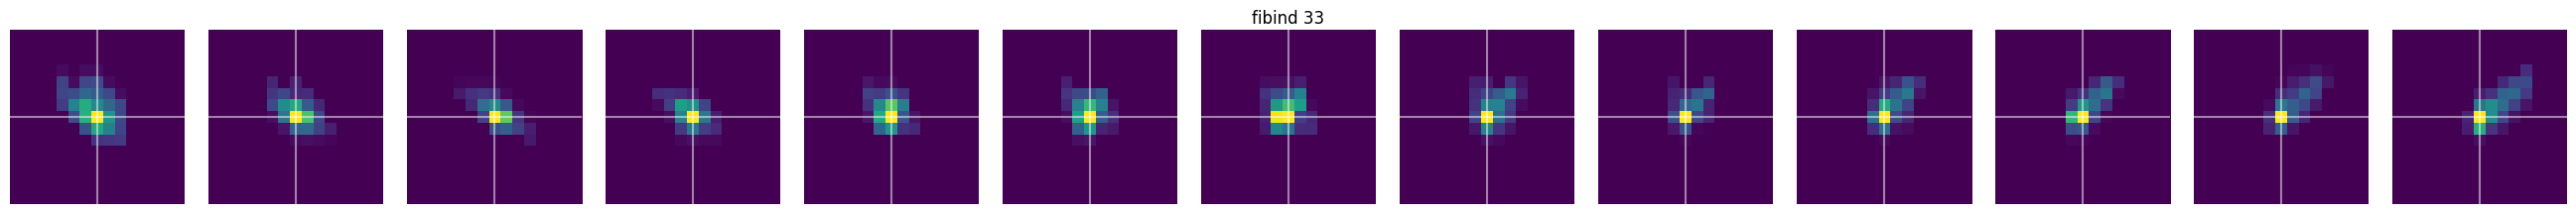

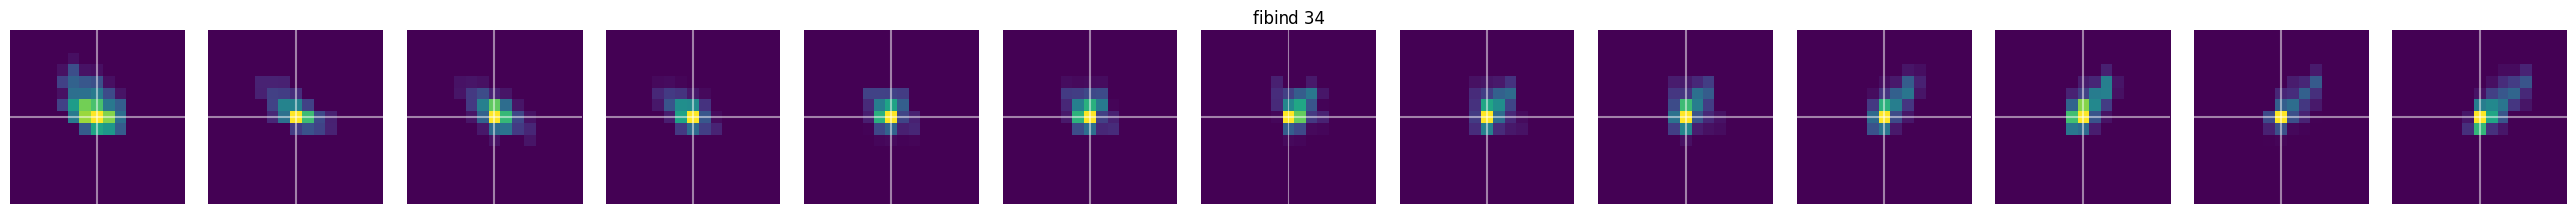

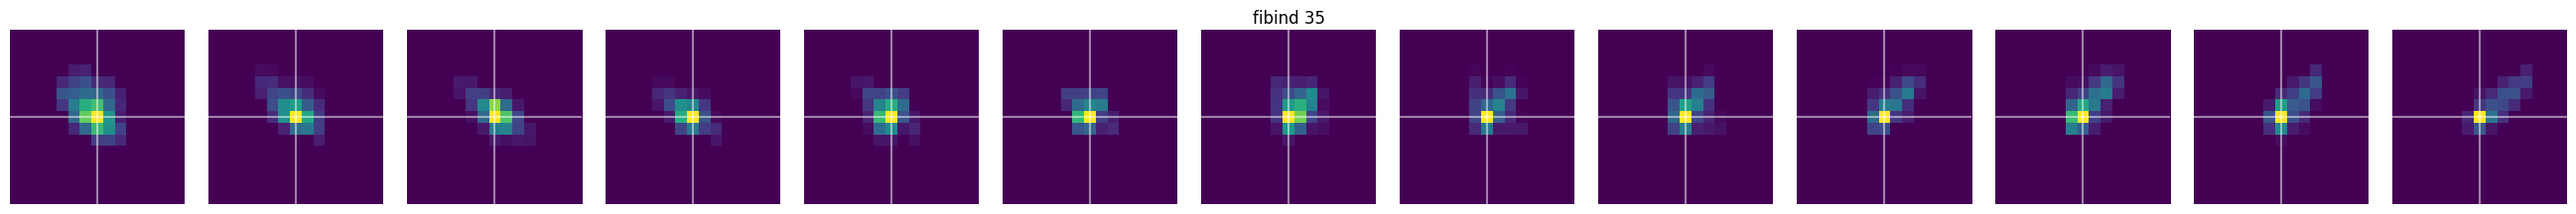

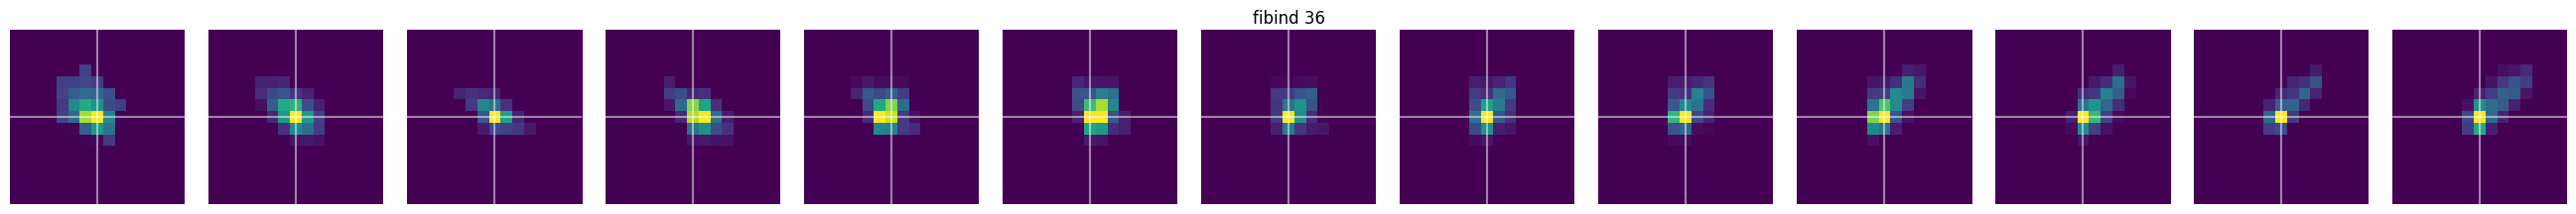

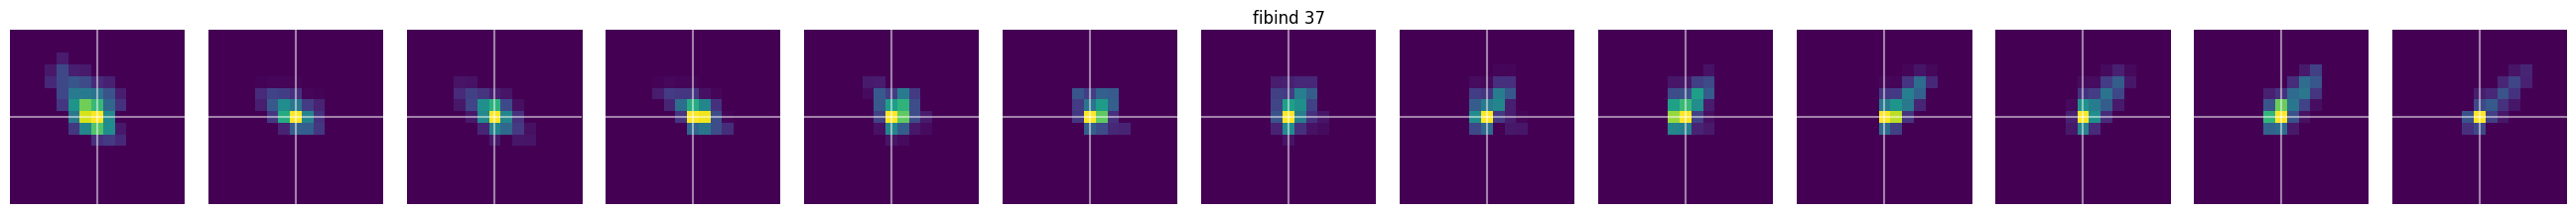

In [34]:
# Make cutout LSFs for LSF modeling
# There are a few parameters to adjust here. Depending on the S/N of the Neon data you may need to adjust the parameters.
# Default values work well in this case.
sm.make_clean_LSF_models()

The next step is to make the spectrum model by placing these LSFs along the trace.

This makes a giant sparse matrix: (Simulated detector image) = (Matrix) (Spectrum) 

For spectral extraction, we can solve a regularized least-squares problem, 

i.e., finding the (spectrum) that minimizes |(Matrix) (Spectrum) - (Measured detector image)|$^2$

For detailed implementation, refer to `construct_matrix` and `extract_spec_optimal` in `spec.py`.

In [11]:
# Define wavelength range for spectral extraction. 
xmin, xmax = 1100, 1300 # pix

We find that small adjustment is needed to center the LSFs properly to the traces. Thus we iteratively construct the matrix by finding the required shift in each trial and applying the shift for the next trial. `n_iter` of 2 or 3 is good.

constructing initial matrix


100%|██████████| 38/38 [01:47<00:00,  2.83s/it]


matrix saved to ./specmodel/ini_matrix.npz
wavmap saved to ./specmodel/ini_wavmap.npy
info saved to ./specmodel/ini_info.npy
constructing matrix for iter 1


100%|██████████| 38/38 [01:47<00:00,  2.82s/it]


matrix saved to ./specmodel/iter0_matrix.npz
wavmap saved to ./specmodel/iter0_wavmap.npy
info saved to ./specmodel/iter0_info.npy


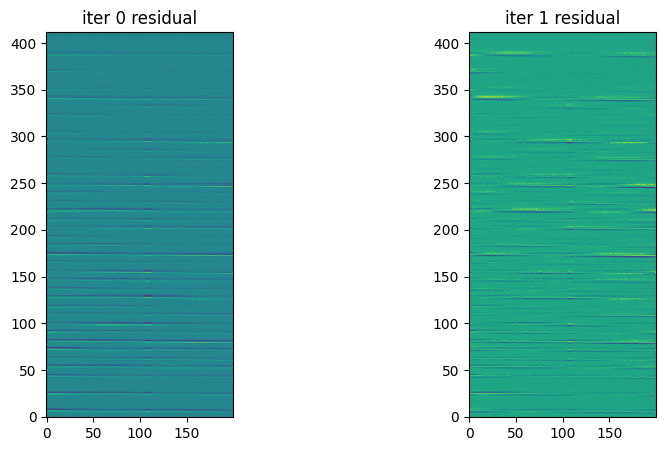

matrix saved to ./specmodel/specmodel_matrix.npz
wavmap saved to ./specmodel/specmodel_wavmap.npy
info saved to ./specmodel/specmodel_info.npy


In [14]:
# Construct matrices. Note this takes a while. 
matrices, ycorr_maps, recons, im = sm.iter_construct_matrix(xmin, xmax, n_iter= 2, save_intermediate = True)
sm.save_spectra_model('specmodel')


In [15]:
# build wavelength calibration

# Range of Neon lines to use for wavelength calibration
neon_range = np.arange(1, 10)
sm.build_wavelength_solutions(neon_range, xmin, xmax, poly_deg = 3)
sm.save_spectra_model('specmodel')


matrix saved to ./specmodel/specmodel_matrix.npz
wavmap saved to ./specmodel/specmodel_wavmap.npy
info saved to ./specmodel/specmodel_info.npy


We can now do optimal spectral extraction using this matrix!

In [ ]:
# Extract spectrum (optimal)
# the parameter "thresh" may need to be adjusted (threshold for damping factor for regularized least-squares)
spec, res = sp.frame_to_spec(target, xmin, xmax, sm.wav_map, matrix = sm.A, return_residual = True)

# Extract spectrum (box)
# this uses traces found in the above.
spec_box = sp.frame_to_spec(target, xmin, xmax, sm.wav_map, traces = np.array(sm.trace_vals)[:,xmin - sm.XMIN:xmax - sm.XMIN],
                            boxsize = 3)

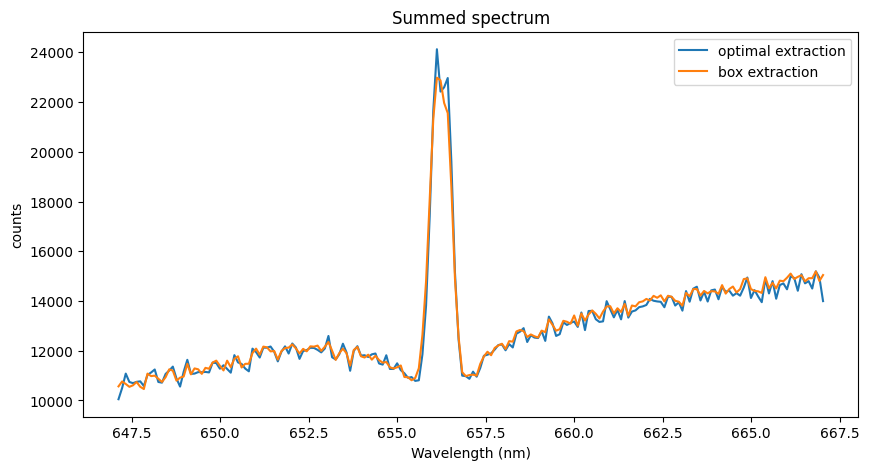

In [33]:
# Plot results (truncated 2 pixels each on the sides that show edge effects)

plt.figure(figsize=(10,5))
plt.plot(sm.wav_map[0][2:-2], np.sum(spec, axis=0)[2:-2], label = 'optimal extraction')
# a small scaling factor is applied to match between the two. The absolute values are not important here.
plt.plot(sm.wav_map[0][2:-2], np.sum(spec_box, axis=0)[2:-2] * 1.16, label = 'box extraction')
plt.xlabel('Wavelength (nm)')
plt.ylabel('counts')
plt.title('Summed spectrum')
plt.legend()
plt.show()

The optimal extraction actually resolves the two peaks of the target spectrum better!